In [83]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import json
import numpy as np
from PIL import Image
import matplotlib.patches as patches
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon

In [27]:
train_seg_folder = r'D:\Work\Challenges\Solafune-Vacant-Slots\datasets\train_segmentation_images'
train_bbox_folder = r'D:\Work\Challenges\Solafune-Vacant-Slots\datasets\train_bbox_images'

train_seg_annotation = r'D:\Work\Challenges\Solafune-Vacant-Slots\datasets\train_segmentation_annotations.json'
train_bbox_annotation = r'D:\Work\Challenges\Solafune-Vacant-Slots\datasets\train_bbox_annotations.json'

# Object Detection : EDA

In [68]:
class ObjectDetectionEDA:
    def __init__(self, annotation_file):
        """
        Initializes the EDA class with the annotation file path.

        Args:
            annotation_file (str): Path to the JSON annotation file.
        """
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_data = self.annotations['images']
        self.class_counts = {}
        self.image_sizes = []
        self.bbox_sizes = []


    def count_classes(self):
        """Counts the occurrences of each class in the dataset."""
        for image in self.image_data:
            for annotation in image['annotations']:
                cls = annotation['class']
                self.class_counts[cls] = self.class_counts.get(cls, 0) + 1

    def plot_class_distribution(self):
        """Plots the distribution of classes."""
        classes = list(self.class_counts.keys())
        counts = list(self.class_counts.values())
        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.title("Class Distribution")
        plt.show()
        
    def calculate_image_and_bbox_sizes(self):
        """Calculates the sizes of images and bounding boxes."""
        for image in self.image_data:
            # Image sizes
            width = image['width']
            height = image['height']
            self.image_sizes.append((width, height))

            # Bounding box sizes
            for annotation in image['annotations']:
                bbox = annotation['bbox']
                bbox_width = bbox[2]
                bbox_height = bbox[3]
                self.bbox_sizes.append((bbox_width, bbox_height))
                
        print(f'Median Image Width: {np.median([x[0] for x in self.image_sizes])}')
        print(f'Median Image Height: {np.median([x[1] for x in self.image_sizes])}')
        print(f'Median Bounding Box Width: {np.median([x[0] for x in self.bbox_sizes])}')
        print(f'Median Bounding Box Height: {np.median([x[1] for x in self.bbox_sizes])}')
                
    def plot_image_and_bbox_sizes(self):
        """Plots the distribution of image and bounding box sizes."""
        image_widths, image_heights = zip(*self.image_sizes)
        bbox_widths, bbox_heights = zip(*self.bbox_sizes)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(image_widths, image_heights, alpha=0.5)
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title("Image Sizes")
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.scatter(bbox_widths, bbox_heights, alpha=0.5, color='r')
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title("Bounding Box Sizes")

        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def visualize_image_with_bboxes(self, image_index, image_dir="."):
        """Visualizes a single image with its segmentation masks overlaid."""
        image_data = self.image_data[image_index]
        image_path = image_dir + "/" + image_data['file_name']

        img = Image.open(image_path)
        img_np = np.array(img)
        fig, ax = plt.subplots(1)
        ax.imshow(img_np)

        # visualize bboxes
        for annotation in image_data['annotations']:
            bbox = annotation['bbox']
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3], 
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            )
            ax.add_patch(rect)
            plt.text(bbox[0], bbox[1]-5, 
                     annotation['class'],
                     color='white', 
                     fontsize=8,
                     bbox=dict(facecolor='none', edgecolor='none', pad=0.0))

        plt.axis('off')
        plt.show()

In [69]:
OD_EDA = ObjectDetectionEDA(train_bbox_annotation)
OD_EDA.count_classes()
OD_EDA.class_counts

{'vacant_lot': 2653}

Median Image Width: 500.0
Median Image Height: 375.0
Median Bounding Box Width: 51.0
Median Bounding Box Height: 47.0


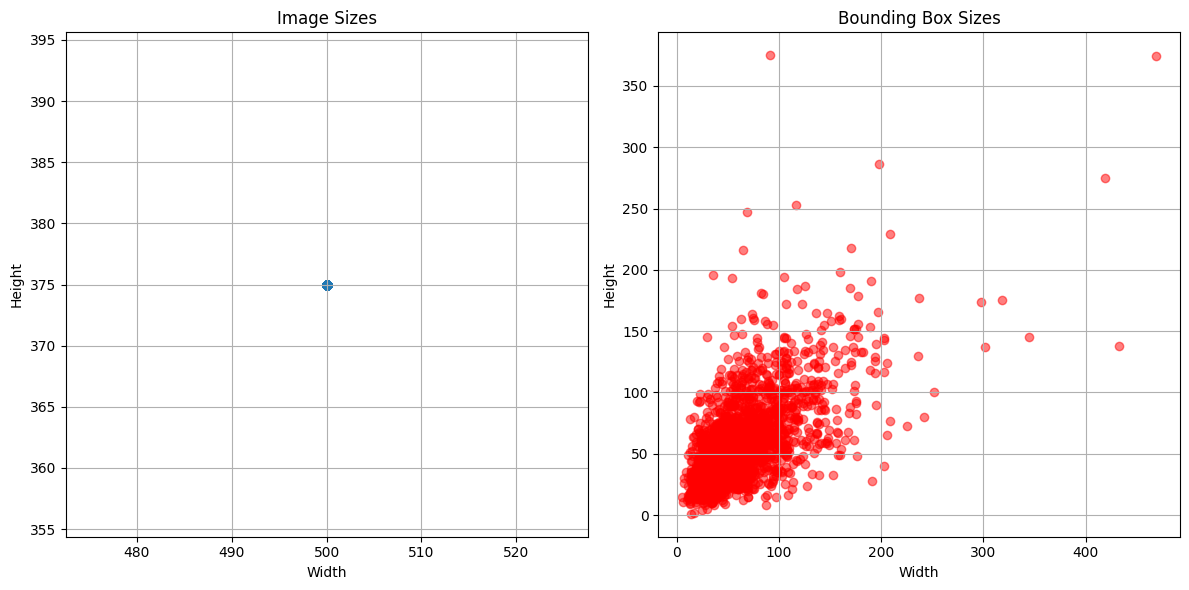

In [70]:
OD_EDA.calculate_image_and_bbox_sizes()
OD_EDA.plot_image_and_bbox_sizes()

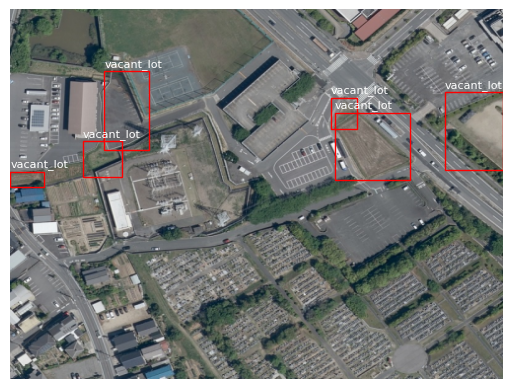

In [71]:
OD_EDA.visualize_image_with_bboxes(210, train_bbox_folder)

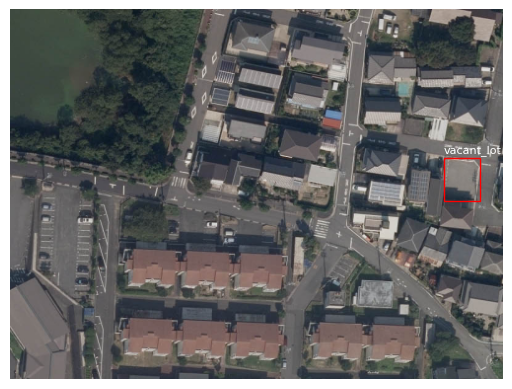

In [72]:
OD_EDA.visualize_image_with_bboxes(2, train_bbox_folder)

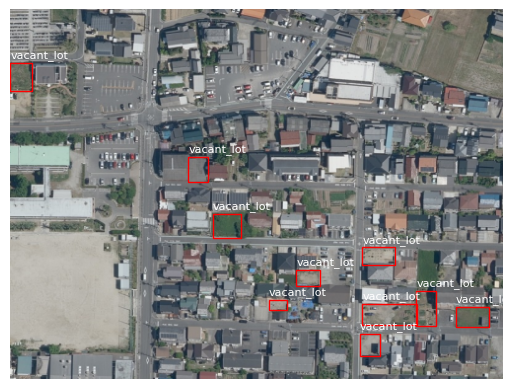

In [73]:
OD_EDA.visualize_image_with_bboxes(67, train_bbox_folder)

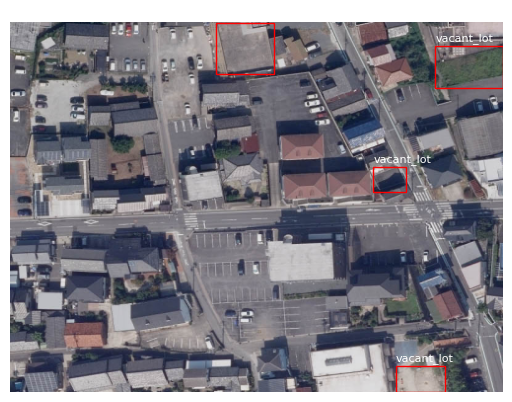

In [74]:
OD_EDA.visualize_image_with_bboxes(167, train_bbox_folder)

# Segmentation : EDA

In [128]:

class SegmentationEDA:
    def __init__(self, annotation_file):
        """
        Initializes the EDA class with the annotation file path.

        Args:
            annotation_file (str): Path to the JSON annotation file.
        """
        with open(annotation_file, 'r') as f:
            self.annotations = json.load(f)
        self.image_data = self.annotations['images']
        self.class_counts = {}
        self.image_sizes = []
        self.mask_areas = []

    def count_classes(self):
        """Counts the occurrences of each class in the dataset."""
        for image in self.image_data:
            for annotation in image['annotations']:
                cls = annotation['class']
                self.class_counts[cls] = self.class_counts.get(cls, 0) + 1

    def _calculate_polygon_area(self, coords):
        """
        Calculate the area of a polygon using the Shoelace formula.
        
        :param coords: List of (x, y) coordinates of the polygon vertices.
        :return: Area of the polygon.
        """
        n = len(coords)  # Number of vertices
        area = 0
        for i in range(n):
            x1, y1 = coords[i]
            x2, y2 = coords[(i + 1) % n]  # Next vertex (wraps around)
            area += x1 * y2 - y1 * x2
        return abs(area) / 2

    def calculate_image_and_mask_areas(self):
        """Calculates the sizes of images and mask areas."""
        for image in self.image_data:
            # Image sizes
            width = image['width']
            height = image['height']
            self.image_sizes.append((width, height))

            # Mask areas
            for annotation in image['annotations']:
                mask = annotation['segmentation']
                # Convert flat list of coordinates into (x, y) pairs
                coords = [(mask[i], mask[i + 1]) for i in range(0, len(mask), 2)]
                # Calculate polygon area using the Shoelace formula
                mask_area = self._calculate_polygon_area(coords)
                self.mask_areas.append(mask_area)

    def plot_class_distribution(self):
        """Plots the distribution of classes."""
        classes = list(self.class_counts.keys())
        counts = list(self.class_counts.values())
        plt.figure(figsize=(10, 6))
        plt.bar(classes, counts)
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.title("Class Distribution")
        plt.show()

    def plot_image_and_mask_areas(self):
        """Plots the distribution of image sizes and mask areas."""
        image_widths, image_heights = zip(*self.image_sizes)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(image_widths, image_heights, alpha=0.5)
        plt.xlabel("Width")
        plt.ylabel("Height")
        plt.title("Image Sizes")

        plt.subplot(1, 2, 2)
        plt.hist(self.mask_areas, bins=50, alpha=0.5, color='r')
        plt.xlabel("Mask Area")
        plt.ylabel("Count")
        plt.title("Mask Areas")
        plt.grid(True)

        plt.tight_layout()
        plt.show()
    
    def visualize_image_with_masks(self, image_index, image_dir="."):
        """Visualizes a single image with its segmentation masks overlaid."""
        image_data = self.image_data[image_index]
        image_path = image_dir + "/" + image_data['file_name']

        img = Image.open(image_path)
        img_np = np.array(img)
        fig, ax = plt.subplots(1)
        ax.imshow(img_np)

        # Step 3: Plot each polygon
        for annotation in image_data['annotations']:
            segmentation = annotation["segmentation"]
            
            # Convert flat list to (x, y) pairs
            polygon_coords = [(segmentation[i], segmentation[i + 1]) for i in range(0, len(segmentation), 2)]
            
            # Create a Polygon and add it to the plot
            polygon = Polygon(polygon_coords, closed=True, 
                              facecolor="blue", alpha=0.2, edgecolor="black")
            ax.add_patch(polygon)

        plt.axis('off')
        plt.show()

In [129]:
SegEDA = SegmentationEDA(train_seg_annotation)
SegEDA.count_classes()
SegEDA.class_counts

{'vacant_lot': 2653}

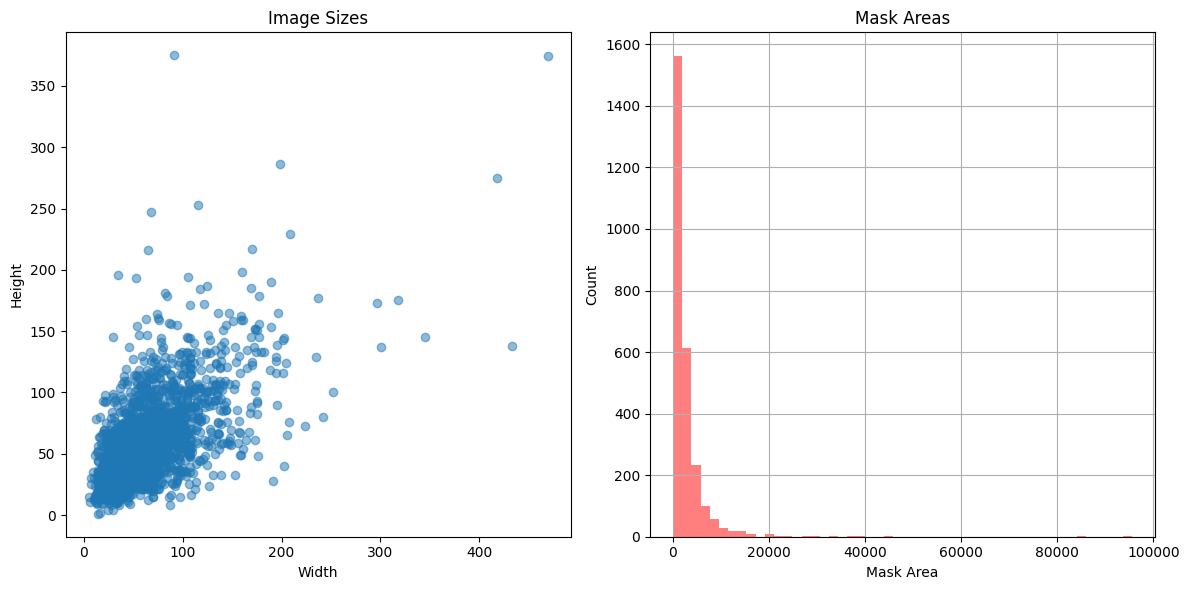

In [130]:
SegEDA.calculate_image_and_mask_areas()
SegEDA.plot_image_and_mask_areas()

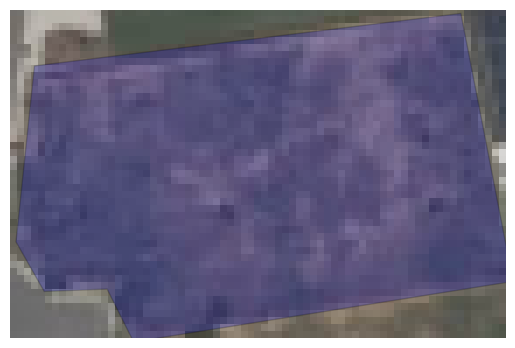

In [ ]:
SegEDA.visualize_image_with_masks(image_index=150, 
                                  image_dir=train_seg_folder)

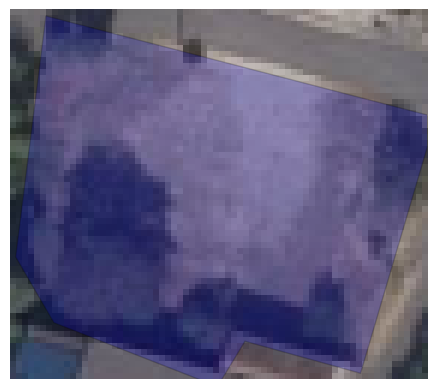

In [99]:
SegEDA.visualize_image_with_masks(image_index=15, 
                                  image_dir=train_seg_folder)

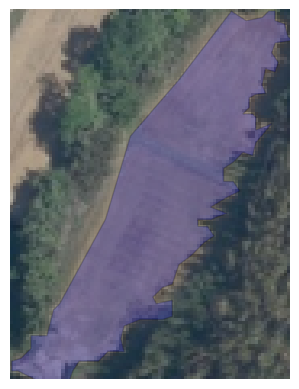

In [120]:
from random import randint
SegEDA.visualize_image_with_masks(image_index=randint(0, len(SegEDA.image_data)),
                                  image_dir=train_seg_folder)